In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import os
import zernike
import hamaker
import parallelize
import time


# Single frequency

In [13]:
ms_path = '/media/plato/cw/cw1/synthms_hba_t201411041558_SBH51.MS'

npix = 2049
f = 130
time = 4.92183348e09
station = 0

J = hamaker.allsky_beam(ms_path, time, f*1e6, station_id=station, npix=npix)

np.save('beam_%i.npy'%(f/1e6), J)


/tmp/ipykernel_1941203/2121162424.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(np.abs(J[:,:,0,0])), extent=(-90,90,-90,90), vmin=-100, vmax=0)


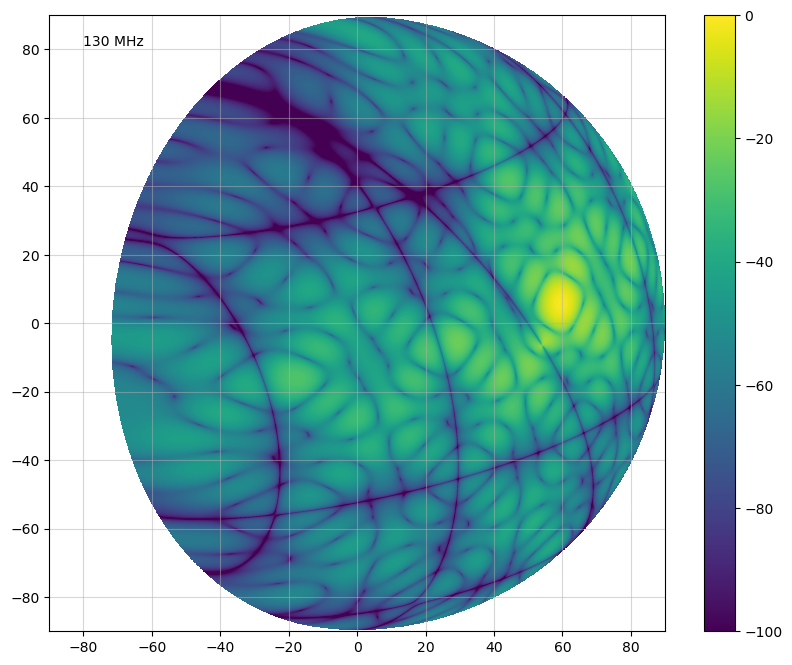

In [16]:
plt.figure(figsize=(10,8))

J = np.load('beam_%i.npy'%f)

plt.imshow(20*np.log10(np.abs(J[:,:,0,0])), extent=(-90,90,-90,90), vmin=-100, vmax=0)
plt.colorbar()
plt.grid(alpha=0.5)
plt.text(-80, 81, "%i MHz"%f);


In [17]:
J[np.isnan(J)] = 0
cent = np.where(np.abs(J[:,:,0,0,])==np.abs(J[:,:,0,0,]).max())
cx, cy = cent[1][0], cent[0][0]
print(cx, cy)

px = 180. / J.shape[0]
r = int(15. / px)

Jz = J[cy-r:cy+r, cx-r:cx+r, :, :]

Jza_db = 20*np.log10(np.abs(Jz))


1700 959


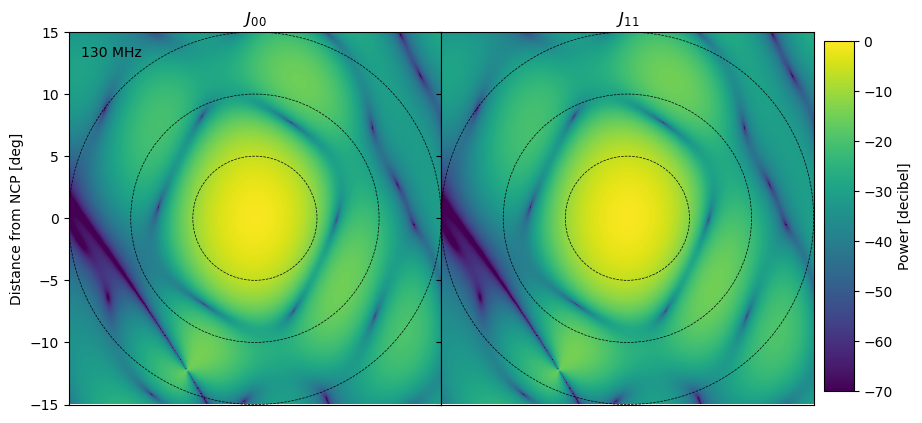

In [20]:
fig = plt.figure(figsize=(10,5), constrained_layout=False)
gs = fig.add_gridspec(1, 2, wspace=0.0, hspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

radii = [5, 10, 15]

for i in range(2):
    im = ax[i].imshow(Jza_db[:,:,i,i], extent=(-15,15,-15,15), vmin=-70, vmax=0)
    ax[i].set_xticks([])
    ax[i].set_title("$J_{%i%i}$"%(i,i))
    for rad in radii: ax[i].add_patch(plt.Circle((0, 0), rad, fill=None, color='k', linestyle='--', linewidth=0.5))

fig.subplots_adjust(right=0.87)
cax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
cb = fig.colorbar(im, cax=cax)
cb.ax.set_ylabel('Power [decibel]')
ax[0].set_ylabel('Distance from NCP [deg]')
ax[0].text(-14, 13, "%i MHz"%f);


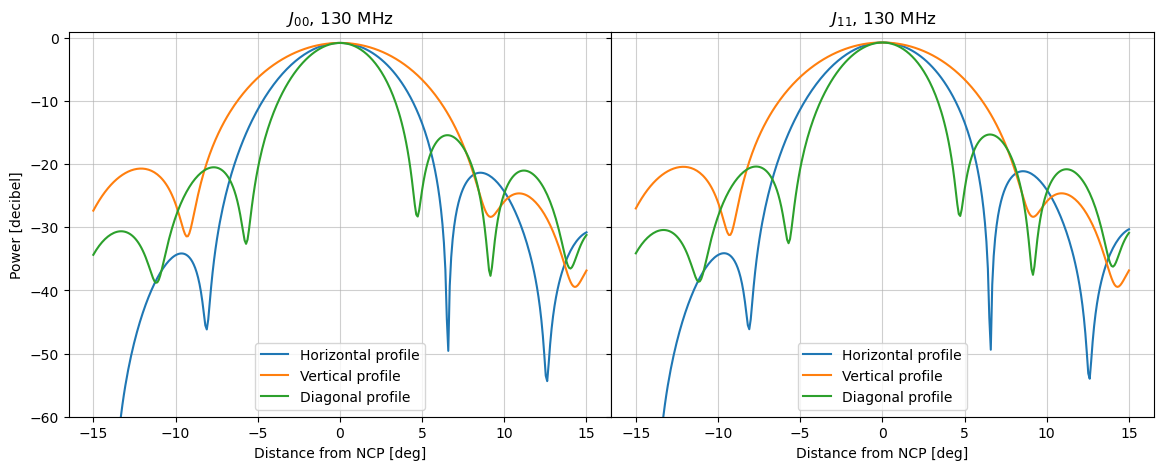

In [23]:
fig = plt.figure(figsize=(14,5), constrained_layout=False)
gs = fig.add_gridspec(1, 2, wspace=0.0, hspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

x = np.linspace(-15,15,r*2)

for i in range(2):
    ax[i].plot(x, Jza_db[r,:,i,i], label='Horizontal profile')
    ax[i].plot(x, Jza_db[:,r,i,i], label='Vertical profile')
    ax[i].plot(x, np.diagonal(Jza_db[:,:,i,i]), label='Diagonal profile')
    ax[i].set_title("$J_{%i%i}$, %i MHz"%(i,i,f))
    ax[i].set_xlabel('Distance from NCP [deg]')
    ax[i].set_ylim([-60,1])
    # ax[i].set_xlim([-15,15])
    ax[i].grid(alpha=.6)
    ax[i].legend();

ax[0].set_ylabel('Power [decibel]');


In [28]:
import zernike

from mpl_toolkits.axes_grid1 import make_axes_locatable

def zernike_decom_recon(data, j=0, modes=200, thresh=35):
    Cr = zernike.decompose(data.real, modes)
    Ci = zernike.decompose(data.imag, modes)
    Mr = zernike.reconstruct(Cr, thresh, data)
    Mi = zernike.reconstruct(Ci, thresh, data)
    mod = np.abs(Mr+1j*Mi)
    
    rho, phi, mask = zernike.unit_disk(mod.shape[0])

    dat = np.abs(data)*mask
    
    res = np.abs(dat-mod)*mask

    fig = plt.figure(figsize=(12, 4), constrained_layout=True)
    gs = fig.add_gridspec(1, 3, wspace=0.0, hspace=0.0)
    ax = gs.subplots(sharex=True, sharey=True)

    imgs = 20*np.log10(np.array([dat, mod, res]))
    
    labels = ['Hamaker', 'Zernike', 'Residual']

    for i in range(3):
        ax[i].axis('off')
        im = ax[i].imshow(imgs[i,...], vmin=-70, vmax=0)
        div = make_axes_locatable(ax[i])
        cax = div.new_vertical(size='5%', pad=0.3)
        fig.add_axes(cax)
        cb = fig.colorbar(im, cax=cax, orientation="horizontal")
        cb.ax.set_xlabel("%s $J_{%i%i}$"%(labels[i],j,j))
        cb.ax.xaxis.set_label_position('top')  
    
    return Cr, Ci, dat, mod, res


/tmp/ipykernel_1941203/4256194838.py:22: RuntimeWarning: divide by zero encountered in log10
  imgs = 20*np.log10(np.array([dat, mod, res]))


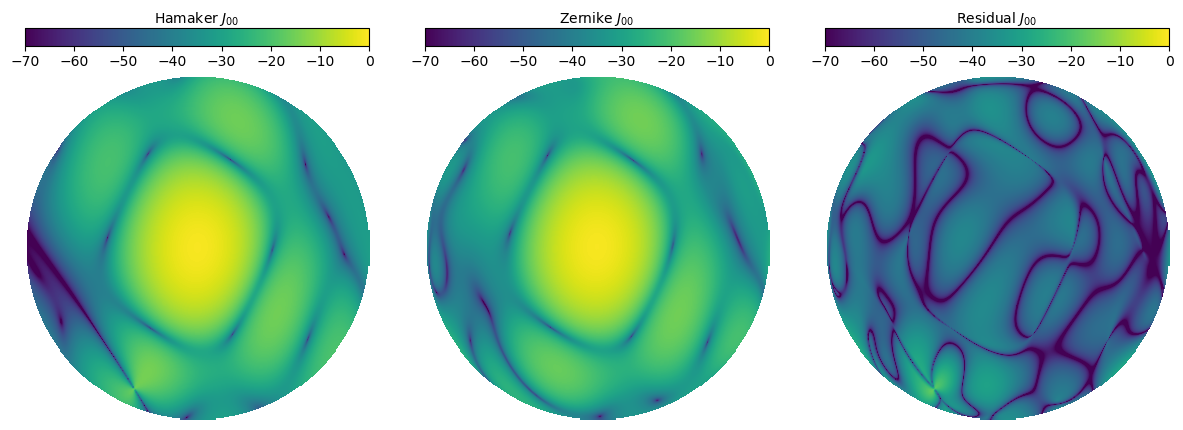

In [29]:
j = 0
zernike_decom_recon(Jz[:,:,j,j], j=j, modes=200, thresh=20); 

# All frequencies

In [2]:
data_path = '/media/plato/lofar/beam/beam_all_freq_cropped.npy'
Jza = np.load(data_path) 

c, r = 169, 85
Jza_cropped = Jza[:, c-r:c+r, c-r:c+r, 0, 0]
Jza_cropped.shape

def zernike_decom(data):
    modes=200
    Cr = zernike.decompose(data.real, modes)
    Ci = zernike.decompose(data.imag, modes)
    return Cr+1j*Ci


In [22]:
Jza_cropped.shape

(61, 170, 170)

In [3]:
start_time = time.time()

j = 0
# Use 80% of available cores
coeffs = np.array(parallelize.parmap(zernike_decom, Jza_cropped, proc_power=0.8))

end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")


Total execution time: 42.12 seconds


/tmp/ipykernel_2267174/3712216493.py:15: RuntimeWarning: divide by zero encountered in log10
  imgs = 20*np.log10(np.array([dat, mod, res]))


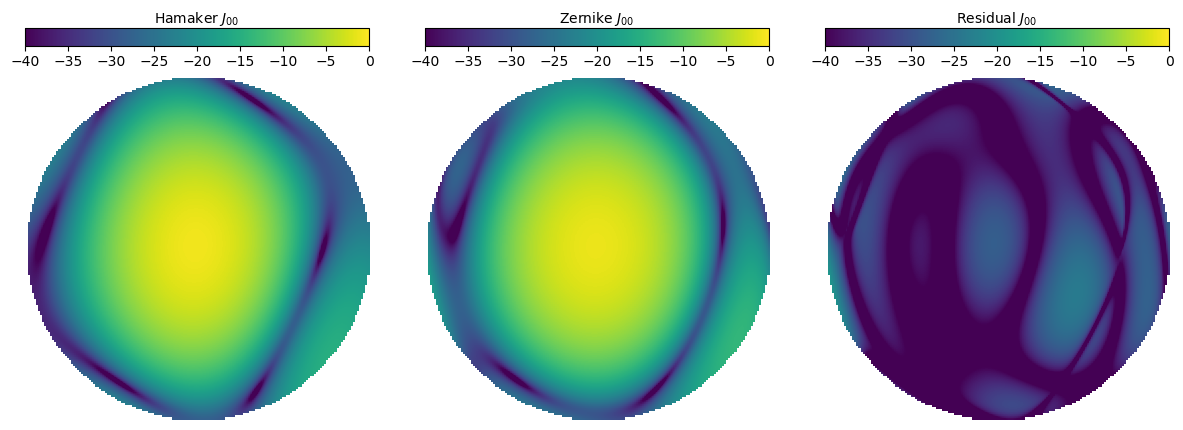

In [60]:
def coeffs_sorting(coeffs, thresh):
    coeffs_avg = np.mean(np.abs(coeffs), axis=0)
    sortind = np.argsort(coeffs_avg)[::-1]
    # plt.plot(coeffs_avg[sortind])
    sorti = sortind[:thresh]
    return coeffs[:,sorti], sorti

thresh = 10
coeffs_r, ind_r = coeffs_sorting(coeffs.real, thresh)
coeffs_i, ind_i = coeffs_sorting(coeffs.imag, thresh)
coeffs_final = coeffs_r + 1j * coeffs_i
coeffs_final.shape
def zernike_recon(coeffs):
    grid_rho,grid_phi, grid_mask = zernike.unit_disk(Jza_cropped.shape[1])
    recon_r = sum(coeffs.real[i] * zernike.zernikel(val, grid_rho, grid_phi)*grid_mask for (i, val) in enumerate(ind_r))
    recon_i = sum(coeffs.imag[i] * zernike.zernikel(val, grid_rho, grid_phi)*grid_mask for (i, val) in enumerate(ind_i))
    return recon_r + 1j * recon_i

models = np.array(parallelize.parmap(zernike_recon, coeffs_final, proc_power=0.8))

chan = 45
visualization_residual(Jza_cropped[chan,:,:], models[chan,:,:], -40, 0);


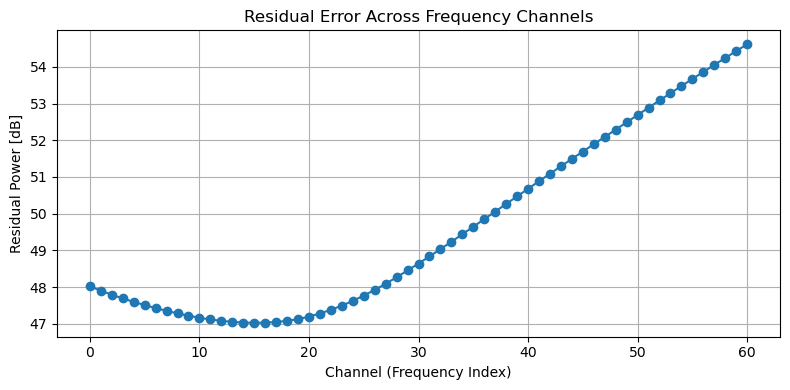

In [61]:
# import matplotlib.pyplot as plt

# for chan in [5,10,15,20,25,30,35,40,45,50,55,60]:  # Channels 0 to 9
#     print(f"Visualizing channel {chan}...")
#     data = Jza_cropped[chan]
#     model = models[chan]
#     res = visualization_residual(data, model, vmin=-40, vmax=0)
#     plt.suptitle(f"Channel {chan} Residual", fontsize=16)
#     plt.show()

residual_powers = []

for chan in range(Jza_cropped.shape[0]):
    data = Jza_cropped[chan]
    model = models[chan]
    
    rho, phi, mask = zernike.unit_disk(data.shape[0])
    dat = np.abs(data) * mask
    mod = np.abs(model) * mask
    res = np.abs(dat - mod) * mask
    
    # Total residual power in dB
    power_db = 20 * np.log10(np.sum(res))
    residual_powers.append(power_db)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(range(len(residual_powers)), residual_powers, marker='o')
plt.xlabel("Channel (Frequency Index)")
plt.ylabel("Residual Power [dB]")
plt.title("Residual Error Across Frequency Channels")
plt.grid(True)
plt.tight_layout()
plt.show()



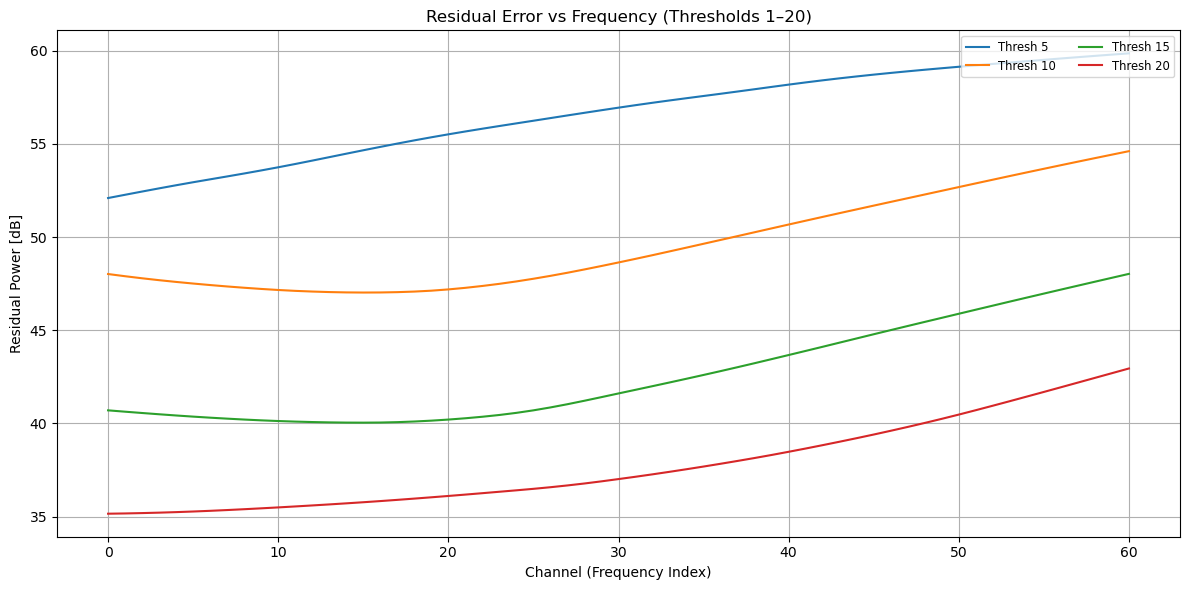

In [65]:
max_thresh = 20
num_channels = Jza_cropped.shape[0]

plt.figure(figsize=(12, 6))

for t in [5,10,15,20]:
    # Recalculate coeffs based on current threshold
    coeffs_r, ind_r = coeffs_sorting(coeffs.real, t)
    coeffs_i, ind_i = coeffs_sorting(coeffs.imag, t)
    coeffs_final = coeffs_r + 1j * coeffs_i

    def zernike_recon(coeffs_sample):
        grid_rho, grid_phi, grid_mask = zernike.unit_disk(Jza_cropped.shape[1])
        recon_r = sum(coeffs_sample.real[i] * zernike.zernikel(val, grid_rho, grid_phi) * grid_mask for i, val in enumerate(ind_r))
        recon_i = sum(coeffs_sample.imag[i] * zernike.zernikel(val, grid_rho, grid_phi) * grid_mask for i, val in enumerate(ind_i))
        return recon_r + 1j * recon_i

    # Build model for all channels
    models_t = np.array([zernike_recon(coeffs_final[i]) for i in range(num_channels)])

    # Compute residual power per channel
    residual_powers = []
    for chan in range(num_channels):
        data = Jza_cropped[chan]
        model = models_t[chan]

        rho, phi, mask = zernike.unit_disk(data.shape[0])
        dat = np.abs(data) * mask
        mod = np.abs(model) * mask
        res = np.abs(dat - mod) * mask

        power_db = 20 * np.log10(np.sum(res))
        residual_powers.append(power_db)

    # Plot this threshold's residuals
    plt.plot(range(num_channels), residual_powers, label=f'Thresh {t}')

# Final plot formatting
plt.xlabel("Channel (Frequency Index)")
plt.ylabel("Residual Power [dB]")
plt.title("Residual Error vs Frequency (Thresholds 1–20)")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
sig = np.std(Jza_cropped[:,:,:] - models[:,:,:], axis=(1,2))


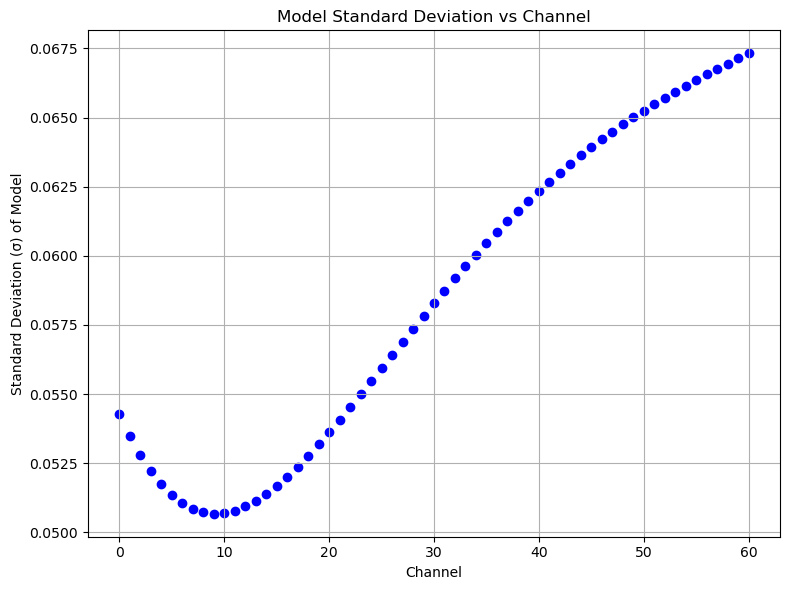

In [59]:
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(61),sig, color='b', label="Residual vs Sig")
plt.ylabel("Standard Deviation (σ) of Model")
plt.xlabel("Channel")
plt.title("Model Standard Deviation vs Channel")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualization_residual(data, model, vmin=-50, vmax=0):
    rho, phi, mask = zernike.unit_disk(data.shape[0])

    dat = np.abs(data)*mask
    mod = np.abs(model)*mask
    
    res = np.abs(dat - mod)*mask

    fig = plt.figure(figsize=(12, 4), constrained_layout=True)
    gs = fig.add_gridspec(1, 3, wspace=0.0, hspace=0.0)
    ax = gs.subplots(sharex=True, sharey=True)

    imgs = 20*np.log10(np.array([dat, mod, res]))
    
    labels = ['Hamaker', 'Zernike', 'Residual']

    for i in range(3):
        ax[i].axis('off')
        im = ax[i].imshow(imgs[i,...], vmin=vmin, vmax=vmax)
        div = make_axes_locatable(ax[i])
        cax = div.new_vertical(size='5%', pad=0.3)
        fig.add_axes(cax)
        cb = fig.colorbar(im, cax=cax, orientation="horizontal")
        cb.ax.set_xlabel("%s $J_{%i%i}$"%(labels[i],j,j))
        cb.ax.xaxis.set_label_position('top')  
    
    return res


Text(0, 0.5, 'Real coefficient energy')

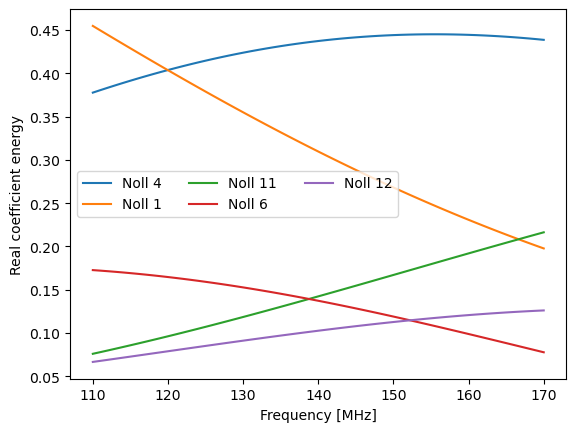

In [7]:
freqs = np.arange(110, 171)

for i in range(5):
    plt.plot(freqs, np.abs(coeffs_r[:,i]), label='Noll %i'%(ind_r[i]+1))

plt.legend(ncol=3)
plt.xlabel('Frequency [MHz]'); plt.ylabel('Real coefficient energy')


Text(0, 0.5, 'Imaginary coefficient energy')

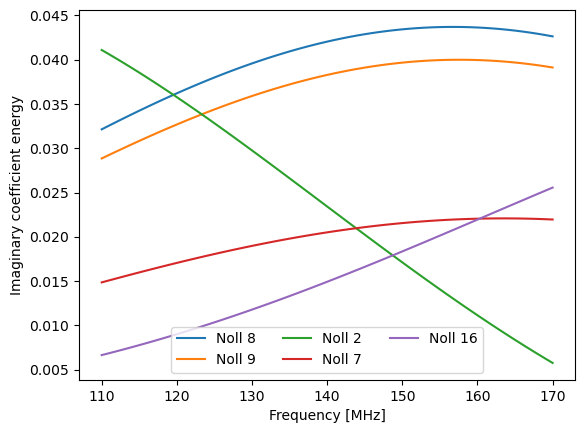

In [8]:
freqs = np.arange(110, 171)

for i in range(5):
    plt.plot(freqs, np.abs(coeffs_i[:,i]), label='Noll %i'%(ind_i[i]+1))

plt.legend(ncol=3)
plt.xlabel('Frequency [MHz]'); plt.ylabel('Imaginary coefficient energy')
